
<font size="12">**Spike cross-correlation demo**</font>

Intro ... what paper to cite


References: 

    1. Garofalo, M., Nieus, T., Massobrio, P., and Martinoia, S. (2009). Evaluation of the Performance of Information Theory-Based Methods and Cross-Correlation to Estimate the Functional Connectivity in Cortical Networks. PLoS ONE 4, e6482. doi: 10.1371/journal.pone.0006482.
    
    2. Nieus, T., D’Andrea, V., Amin, H., Di Marco, S., Safaai, H., Maccione, A., et al. (2018). State-dependent representation of stimulus-evoked activity in high-density recordings of neural cultures. Sci Rep 8, 5578. doi: 10.1038/s41598-018-23853-x.

In [17]:
import numpy as np
import pylab as plt

In [18]:
import spike_cross_corr as scc

# Load data and perform some preliminary analysis

In [19]:
fn = 'data/data.npy'
spk_trains_tmp, id_ch_tmp, tmax = scc.load_data(fn)
tmax /= 1000 # tmax in seconds
print('%d spike trains loaded ' % len(spk_trains_tmp))
print('max time of recording (s) %g ' %tmax)

793 spike trains loaded 
max time of recording (s) 565.398 


## Filter data.

In [20]:
mfr_min = 0.1 # Hz
spk_trains, id_ch = [], []
mfr_lst = []
for st, ic in zip(spk_trains_tmp, id_ch_tmp):
    mfr = len(st) / tmax  # Hz    
    if mfr > mfr_min:
        # spike train has enough spikes
        spk_trains.append(st)
        id_ch.append(ic)
        mfr_lst.append(mfr)
print('%d spike trains retained ' % len(spk_trains))        

793 spike trains retained 


## Report distribution of mean firing rates.

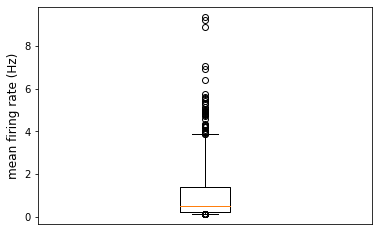

In [21]:
plt.boxplot(mfr_lst, whis=[5, 95])
plt.xticks([])
plt.ylabel('mean firing rate (Hz)', fontsize=12);

# Compute spike cross-correlation

In [22]:
# Format data to run cross-correlation procedure.
idx_spk_tr, len_spk_tr = scc.format_spike_train(spk_trains)

In [23]:
n_jobs = 4
cc_lst, idx_sd, tcc = scc.run_cross_par(idx_spk_tr, len_spk_tr, n_jobs=n_jobs)

cross-corr computed in 107.984 seconds


## Analyze the correlations

In [24]:
# Define some useful functions

def get_row_col(id_ch):
    """Return row and column of channel id_ch."""
    row = id_ch // 64
    col = id_ch % 64    
    return row, col

def chan_dist(rc_src, rc_dst):
    """Compute distance between two channels/electrodes."""
    pitch = 80 # um
    d2 = (rc_src[0] - rc_dst[0])**2 + (rc_src[1] - rc_dst[1])**2
    d = np.sqrt(d2) * pitch
    return d

In [25]:
cc_max = np.zeros(len(cc_lst))
for k, cc in enumerate(cc_lst):
    cc_max[k] = np.max(cc)
idx_rank = np.argsort(cc_max)[::-1] # from highest to lowest

In [35]:
num_links = 30

In [36]:
print('distance (um), t(cc_peak) (ms), cc_peak, velocity (mm/s)')
for count in range(num_links):
    idx_choose = idx_rank[count]
    idx_max = np.argmax(cc_lst[idx_choose])
    t_peak = tcc[idx_max]
    # 
    idx_src, idx_dst = idx_sd[idx_choose]
    # get row/col from id_ch
    rc_src = get_row_col(id_ch[idx_src])
    rc_dst = get_row_col(id_ch[idx_dst])
    dist = chan_dist(rc_src, rc_dst)
    if t_peak:
        vel = dist / t_peak  # um / ms = mm/s
    else:
        vel = 1e10
    print('%g, %g, %g, %g' % (dist, t_peak, cc_max[idx_choose], vel))

distance (um), t(cc_peak) (ms), cc_peak, velocity (mm/s)
80, 0, 0.393688, 1e+10
80, 0.5, 0.393072, 160
252.982, 1.5, 0.233971, 168.655
288.444, -0.5, 0.232833, -576.888
80, 0, 0.134928, 1e+10
288.444, 0.5, 0.133242, 576.888
4882.62, -2.5, 0.1322, -1953.05
80, 0, 0.126762, 1e+10
80, 0, 0.124308, 1e+10
80, 0, 0.123967, 1e+10
80, 0, 0.118173, 1e+10
80, 0, 0.116482, 1e+10
80, 0, 0.112668, 1e+10
80, 0, 0.109528, 1e+10
160, -0.5, 0.108382, -320
252.982, 0, 0.10065, 1e+10
329.848, -0.5, 0.100296, -659.697
80, 0, 0.100277, 1e+10
339.411, 1, 0.100149, 339.411
226.274, -2, 0.0990451, -113.137
113.137, 0, 0.0987811, 1e+10
80, 1.5, 0.0987806, 53.3333
113.137, -1, 0.0954465, -113.137
113.137, -0.5, 0.095289, -226.274
80, 0, 0.0936, 1e+10
80, 0, 0.0890192, 1e+10
80, -0.5, 0.0880698, -160
357.771, 0.5, 0.0876601, 715.542
80, 0.5, 0.0867529, 160
113.137, -0.5, 0.0862085, -226.274


In [ ]:
"""
plt.plot(tcc, cc_lst[idx_choose], c='k', lw=2)
src, dst = idx_sd[idx_choose]
plt.title('%d -> %d' % (src, dst), fontsize=14)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time lag (ms)', fontsize=14)
plt.ylabel('cross correlation', fontsize=14);
"""